### 0. Importing Required Modules

In [2]:
import pandas as pd
import requests
import os
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import math
from sklearn.metrics import mean_squared_error

### 1. Getting the Data

In [4]:
data_source = "alphavantage"
api_key = "FPR74LJ6B7U3Y6RK" 
ticker = "AAPL" #Listed Stock Name 
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key) # JSON file with all the stock market data for JP Morgan from the last 20 years
file_to_saveas = 'stock_market_data-%s.csv'%ticker

In [5]:
if not os.path.exists(file_to_saveas): # If file does not exist
     try:
         response = requests.get(url_string) # Gets the data from URL as a request.Response object
         response.raise_for_status() # Raises errors for HTTP issues
         json_data = response.json() # Converts Response object to readable JSON
         json_data = json_data['Time Series (Daily)'] # Reassigns json_data to the dictionary containing only the time series data, eliminating metadata
         df = pd.DataFrame(columns = ['Date', 'Low', 'High', 'Close', 'Open']) # Constructor for pandas dataframe
         for k, v in json_data.items(): # k(key) is the date, v(value) is the dictionary containing the high, low, open and close prices
             date = dt.datetime.strptime(k, '%Y-%m-%d') # Converting date in data from string to datetime object
             data_row = [date.date(), float(v['3. low']), float(v['2. high']), float(v['4. close']), float(v['1. open'])] # List of elements to add to the dataframe
             df.loc[len(df)] = data_row # Appending list of elements to dataframe
         df.set_index('Date', inplace=True) # Sets the index of the dataframe as the Data Column
         df.sort_index(inplace=True) # Sorts the dataframe in ascending order with respect to the date column
         df.to_csv(file_to_saveas) # Saving pandas dataframe as CSV
         print("Data saved to filename : %s"%(file_to_saveas))
     except Exception as e: print(e)
else:
     print('File already exists. Loading data from CSV')
     df = pd.read_csv(file_to_saveas) # Making pandas dataframe from CSV

File already exists. Loading data from CSV


In [6]:
print(df.tail()) # Test

            Date     Low     High   Close    Open
6223  2024-07-29  215.75  219.300  218.24  216.96
6224  2024-07-30  216.12  220.325  218.80  219.19
6225  2024-07-31  220.63  223.820  222.08  221.44
6226  2024-08-01  217.02  224.480  218.36  224.37
6227  2024-08-02  217.71  225.600  219.86  219.15


### 2. Data Preprocessing

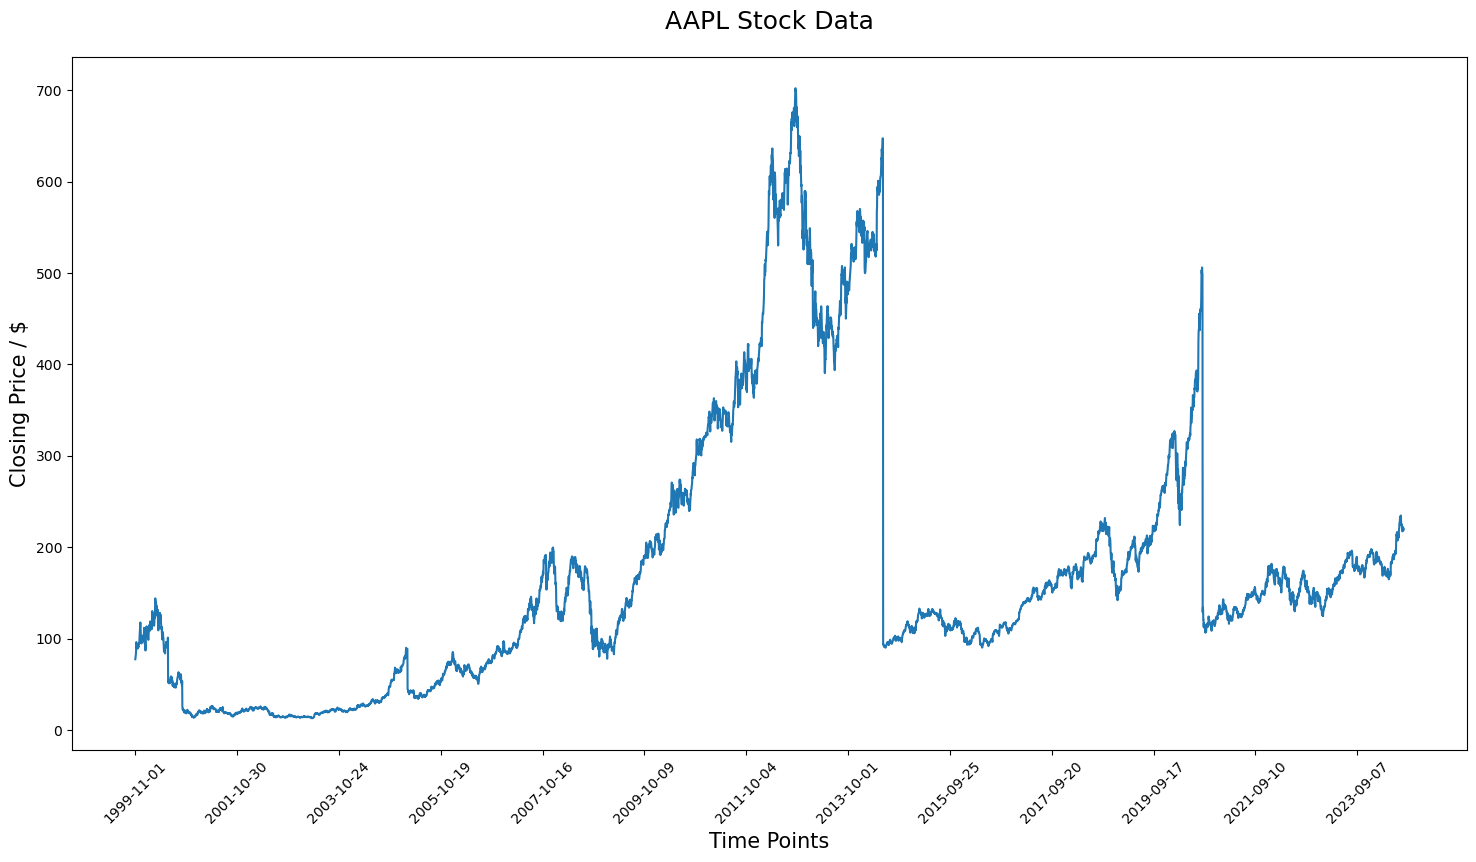

In [8]:
# VISUALIZATION

plt.figure(figsize = (18, 9)) # sets the size of the figure to be 18 inches wide and 9 inches tall 
plt.plot(range(df.shape[0]), (df['Close'])) #plots graph of parameters x(df.shape[0] = total no. of rows i.e. values) and y(average price of that day)
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Time Points', fontsize = 15)
plt.ylabel('Closing Price / $', fontsize = 15)
plt.title("%s Stock Data"%(ticker), fontsize = 18, pad = 20)
plt.show()

In [9]:
closing_prices = df.loc[:, 'Close'].to_numpy().reshape(-1, 1) # Use to_numpy().reshape(-1, 1) if you need a 2D array for operations that require specific input shapes, such as in scikit-learn where many functions expect 2D arrays for features.
training_size = int(len(closing_prices) * 0.60)
train_data = closing_prices[:training_size].reshape(-1, 1) # First <training_size> values are training data, (x,) to (x, 1)
test_data = closing_prices[training_size:].reshape(-1, 1) # Remaining values are test data

scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

all_normalized_data = np.concatenate([train_data, test_data], axis=0)

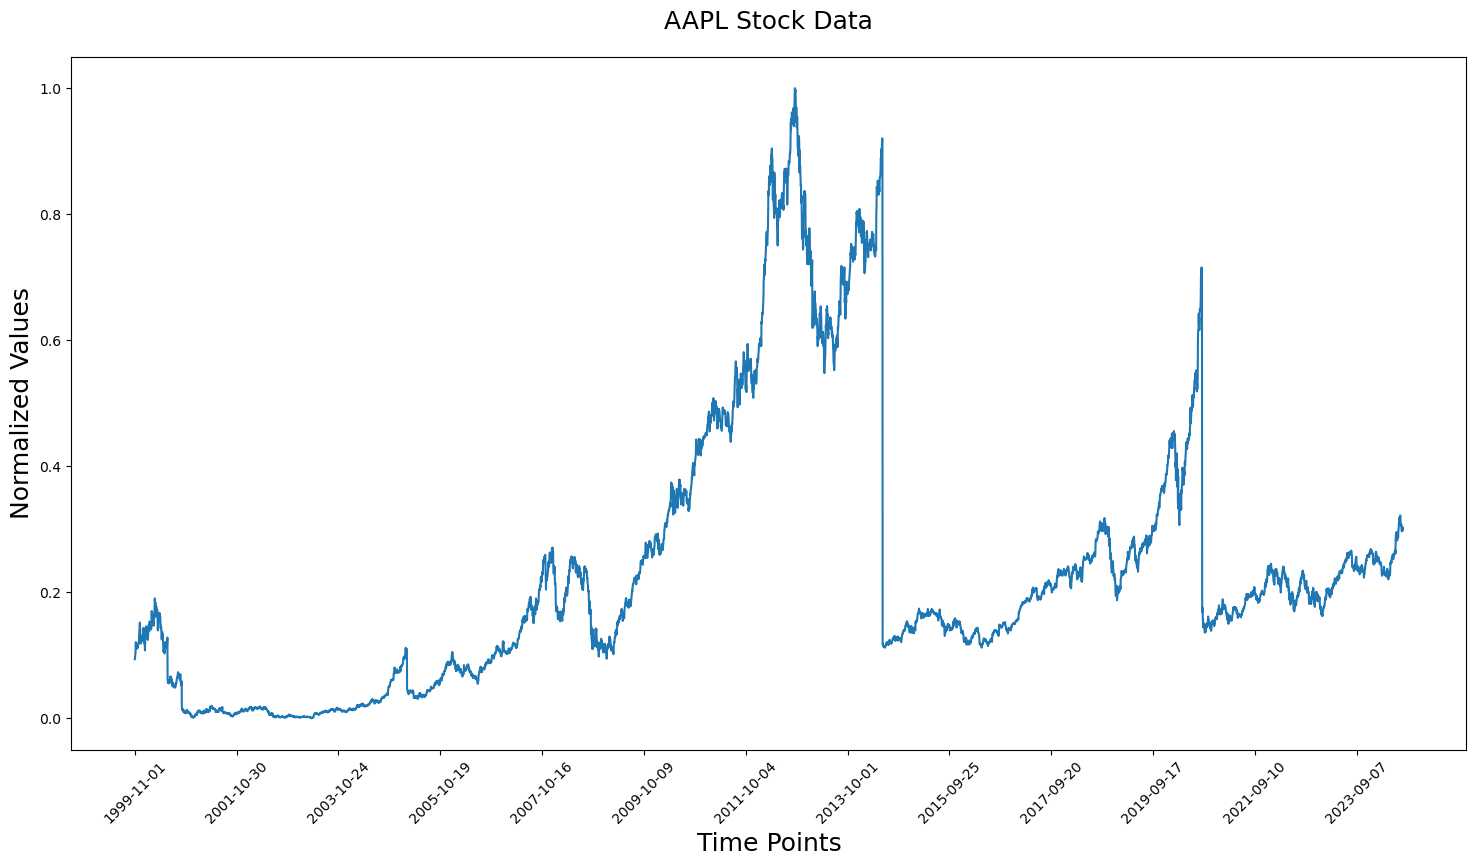

In [10]:
# VISUALIZATION
plt.figure(figsize=(18,9))
plt.plot(range(df.shape[0]), all_normalized_data)
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45) # parameters = plt.xticks(how many ticks, what to label those ticks, rotation of labels)
plt.xlabel('Time Points', fontsize = 18)
plt.ylabel('Normalized Values', fontsize = 18)
plt.title("%s Stock Data"%(ticker), fontsize = 18, pad = 20)
plt.show()

### 3. Data Generation
**VARIABLE EXPLANATION**
- *xtrain* - collection of sequences consisting of <timesteps> no. of training data
- *ytrain* - the training data immediately following the sequence with the corresponding index (actual output to train the model)
- *xtest* - collection of sequences consisting of <timesteps> no. of testing data
- *ytest* - the testing data immediately following the sequence with the corresponding index (actual output to test the model)

In [12]:
def CreateDataMatrix(dataset, timestep=2): # One Day Ahead
     independant_data, dependant_data = [], []
     for i in range(len(dataset)-timestep-1):
         data_row = dataset[i:i+timestep, 0]
         independant_data.append(data_row)
         dependant_data.append(dataset[i+timestep, 0])
     return np.array(independant_data), np.array(dependant_data)

timestep = len(closing_prices) // 40
xtrain, ytrain = CreateDataMatrix(train_data, timestep)
xtest, ytest = CreateDataMatrix(test_data, timestep)

In [13]:
#Testing
print(train_data.shape, test_data.shape)
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(3736, 1) (2492, 1)
(3580, 155) (3580,)
(2336, 155) (2336,)


In [14]:
xtrain = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1)
xtest = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)

print(xtrain.shape, ytrain.shape) # Test
print(xtest.shape, ytest.shape) # Test

(3580, 155, 1) (3580,)
(2336, 155, 1) (2336,)


In [56]:
tf.keras.backend.clear_session()

input_shape = Input(shape=(timestep, 1))
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape = (timestep, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())

NameError: name 'Input' is not defined

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(xtrain, ytrain, validation_data = (xtest, ytest), epochs=50, batch_size = 64, verbose = 1, callbacks=[early_stopping]) # Training the LSTM Model

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 253ms/step - loss: 0.0264 - val_loss: 0.0013
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - loss: 0.0021 - val_loss: 8.6143e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step - loss: 0.0018 - val_loss: 8.3378e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - loss: 0.0016 - val_loss: 6.9754e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - loss: 0.0012 - val_loss: 6.3972e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - loss: 0.0011 - val_loss: 6.1853e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - loss: 0.0011 - val_loss: 5.4676e-04
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 246ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - loss: 0.0011 - val_loss: 4.9145e-04
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - loss: 0.0015 - val_loss: 5.3066e-04
Epoch 12/

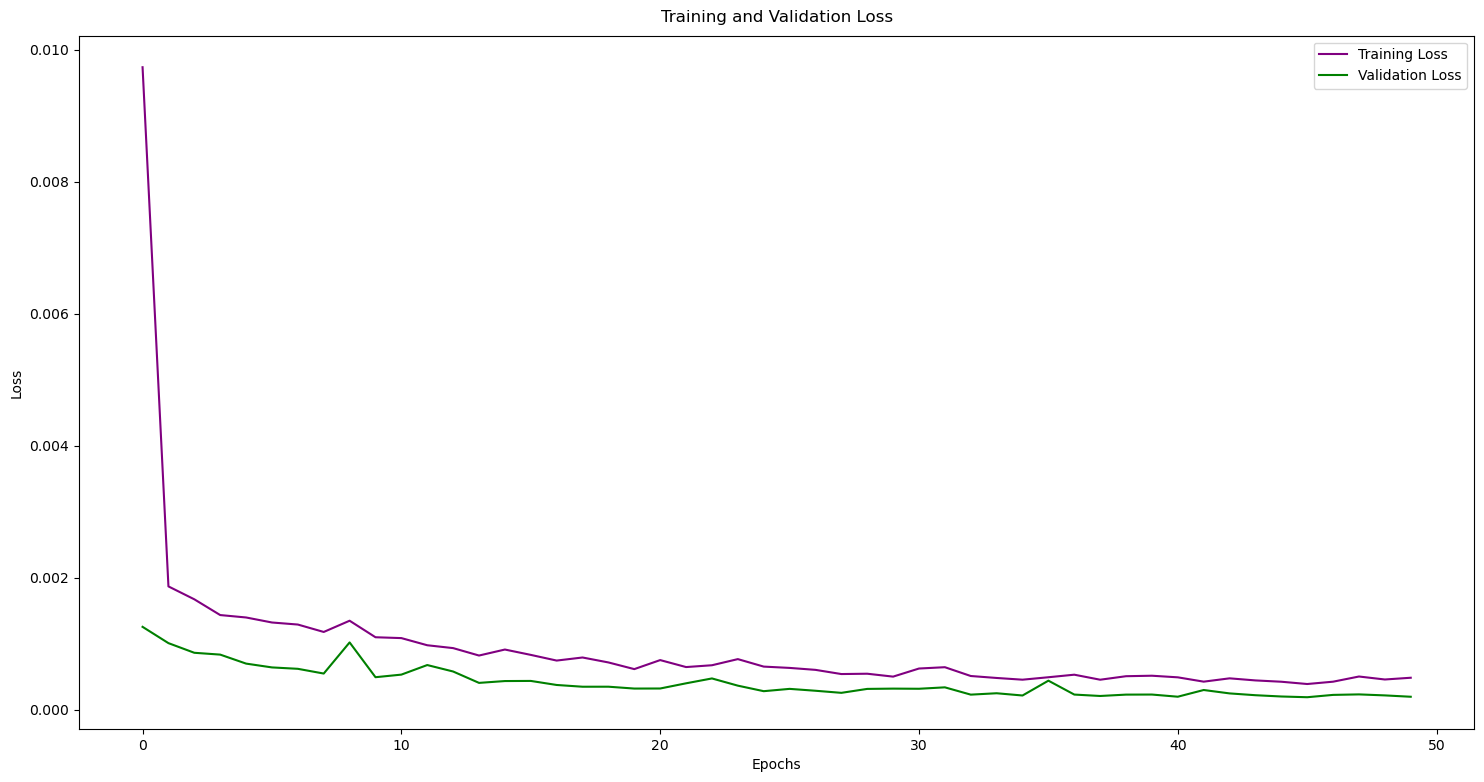

In [54]:
# VISUALIZING THE TRAINING LOSS AGAINST VALIDATION LOSS

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 9))
plt.plot(loss, color='purple', label='Training Loss')
plt.plot(val_loss,  color = 'green', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss', pad=10)
plt.legend()
plt.show()

In [18]:
train_predict = model.predict(xtrain)
test_predict = model.predict(xtest)

112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


In [19]:
ytrain = ytrain.reshape(ytrain.shape[0], 1)
ytest = ytest.reshape(ytest.shape[0], 1)

In [20]:
print(math.sqrt(mean_squared_error(ytrain, train_predict))) # RMSE Performance Metrics over Training Data
print(math.sqrt(mean_squared_error(ytest, test_predict)))  # RMSE Performance Metrics over Testing Data

0.016421852905409866
0.013717527957613307


In [21]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

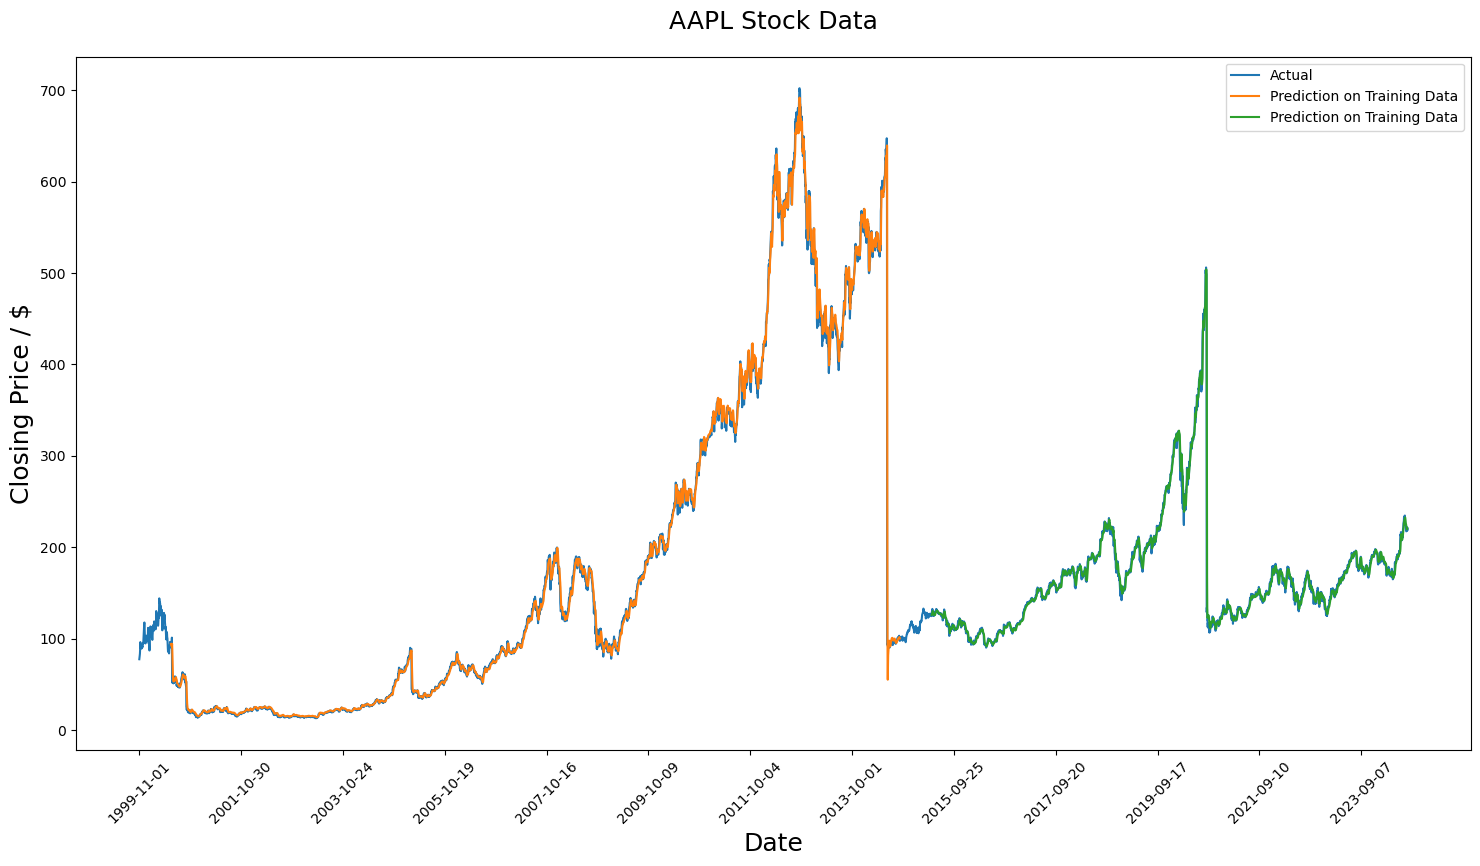

In [50]:
train_predict_plot = np.empty_like(closing_prices) # Initializing an empty array of the same shape as <closing prices>
train_predict_plot[:, :] = np.nan # Filling all elements in the array with NaN i.e. Not a Number which helps in visualizing gaps where predictions do not exist
train_predict_plot[timestep:len(train_predict) + timestep, :] = train_predict 

test_predict_plot = np.empty_like(closing_prices) # Initializing an empty array of the same shape as <closing prices>
test_predict_plot[:, :] = np.nan # Filling all elements in the array with NaN i.e. Not a Number which helps in visualizing gaps where predictions do not exist
test_predict_plot[len(train_predict) + (timestep * 2) + 1:len(closing_prices) - 1, :] = test_predict

plt.figure(figsize=(18,9))
plt.plot(df.index, closing_prices, label='Actual')
plt.plot(df.index, train_predict_plot, label='Prediction on Training Data')
plt.plot(df.index, test_predict_plot, label='Prediction on Training Data')
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Closing Price / $', fontsize = 18)
plt.title("%s Stock Data"%(ticker), fontsize = 18, pad = 20)
plt.legend()
plt.show()